In [1]:
# === CELL 1 — Imports & Config ===
# Purpose: load libraries, set file paths, and declare basic config/primitives.

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

# --- CONFIG
CSV_PATH = r"C:\Users\Vex\Desktop\football\dataset\matchday\clean_matchday_stat.csv"  # input CSV (edit if needed)
TEAM_A_HINT = "Leverkusen"   # fuzzy team hint for Team A
TEAM_B_HINT = "Bayern"       # fuzzy team hint for Team B

RNG = np.random.default_rng(123)  # single RNG for Monte Carlo reproducibility
pd.set_option("display.max_columns", 200)
print("Using:", CSV_PATH)


Using: C:\Users\Vex\Desktop\football\dataset\matchday\clean_matchday_stat.csv


In [2]:
# === CELL 2 — Load CSV, resolve columns, build long (Home then Away) ===
# Purpose: read data, coerce numerics, build team-perspective "long" table with home rows then away rows.

df = pd.read_csv(CSV_PATH)

# Column resolution (expects these exact headers; extend lists if your file differs)
aliases = {
    "home_team":["home_team"], "away_team":["away_team"],
    "home_score":["home_score"], "away_score":["away_score"],
    "xg_home":["expected_goals_xg_home"], "xg_away":["expected_goals_xg_host"],
    "date":["Date_day"],
    "home_goal_times":["home_team_goals_current_time"],
    "away_goal_times":["away_team_goals_current_time"]
}
res = {}
for k, opts in aliases.items():
    for c in opts:
        if c in df.columns:
            res[k] = c
            break

required = ["home_team","away_team","home_score","away_score","xg_home","xg_away"]
miss = [k for k in required if k not in res]
if miss:
    raise ValueError(f"Missing columns: {miss}")

H, A   = res["home_team"], res["away_team"]
FTHG, FTAG = res["home_score"], res["away_score"]
XGH, XGA   = res["xg_home"],    res["xg_away"]
DATE       = res.get("date")

# Coerce score/xG types (scores→int; xG→float)
for c in [FTHG, FTAG]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
for c in [XGH, XGA]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Chronological order column (date if available; else row index)
if DATE and DATE in df.columns:
    df["_order"] = pd.to_datetime(df[DATE], errors="coerce")
else:
    df["_order"] = np.arange(len(df))

# Observed points from final score (per match perspective)
h_pts = np.select([df[FTHG] > df[FTAG], df[FTHG] == df[FTAG], df[FTHG] < df[FTAG]], [3, 1, 0])
a_pts = np.select([df[FTHG] < df[FTAG], df[FTHG] == df[FTAG], df[FTHG] > df[FTAG]], [3, 1, 0])

# Build team-perspective rows (HOME block first, then AWAY block)
home = pd.DataFrame({
    "team": df[H], "opponent": df[A], "venue": "Home", "order": df["_order"],
    "gf": df[FTHG], "ga": df[FTAG],
    "xg_for": df[XGH], "xg_against": df[XGA],
    "obs_pts": h_pts
})
away = pd.DataFrame({
    "team": df[A], "opponent": df[H], "venue": "Away", "order": df["_order"],
    "gf": df[FTAG], "ga": df[FTHG],
    "xg_for": df[XGA], "xg_against": df[XGH],
    "obs_pts": a_pts
})
long = pd.concat([home, away], ignore_index=True)
long["venue_home"] = (long["venue"] == "Home").astype(int)  # 1 for home, 0 for away

# Match block indices inside 'long' (used by simulator)
M = len(df)
home_rows = np.arange(M)          # 0..M-1 (home)
away_rows = np.arange(M, 2*M)     # M..2M-1 (away)

# Fuzzy team-name pickers based on hints
def pick(hint):
    u = long["team"].unique().tolist()
    m = [t for t in u if hint.lower() in str(t).lower()]
    return m[0] if m else None

TEAM_A = pick(TEAM_A_HINT) or "Bayer Leverkusen"
TEAM_B = pick(TEAM_B_HINT) or "Bayern Munich"
print("Shapes — df:", df.shape, "| long:", long.shape)
print("Teams detected:", TEAM_A, "|", TEAM_B)


Shapes — df: (306, 78) | long: (612, 10)
Teams detected: Bayer Leverkusen | Bayern Munich


In [3]:
# === CELL 3 — OOF GBM Expected Points → Skill% & Luck% ===
# Purpose: learn expected points from features (OOF to avoid leakage) and decompose each match into Skill vs Luck.

num_cols = ["xg_for", "xg_against", "venue_home"]
cat_cols = ["team", "opponent", "venue"]

# Version-safe OneHotEncoder (handles sklearn API changes)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocess numeric (median impute) + categorical (most_frequent + one-hot)
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)]), cat_cols)
])

gbm  = GradientBoostingRegressor(random_state=42)
pipe = Pipeline([("prep", pre), ("gbm", gbm)])

X = long[num_cols + cat_cols]
y = long["obs_pts"].astype(float)

# 5-fold OOF predictions, then refit on all data for later use
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(long))
for tr, te in kf.split(X, y):
    pipe.fit(X.iloc[tr], y.iloc[tr])
    oof[te] = pipe.predict(X.iloc[te])
pipe.fit(X, y)

long["exp_pts"] = oof  # expected points per team-match row (OOF)

# Skill/Luck split relative to a neutral baseline b=1.0 point
BASELINE_B = 1.0
def skill_luck(obs, exp, b=BASELINE_B):
    S = abs(exp - b)   # modeled deviation from baseline = "skill"
    U = abs(obs - exp) # residual deviation from model = "luck"
    d = S + U
    if d == 0:
        return 0.5, 0.5
    return S/d, U/d

sk, lk = zip(*[skill_luck(o, e) for o, e in zip(long["obs_pts"], long["exp_pts"])])
long["skill_pct"] = np.array(sk, float)
long["luck_pct"]  = np.array(lk, float)
print("Mean expected pts (OOF):", long["exp_pts"].mean())


Mean expected pts (OOF): 1.3927734347372107


In [4]:
# === CELL 4 — Late-Goal Flags (≥88′ / ≥90′) & Team Indices ===
# Purpose: derive late-decider flags per match and team-level indices (Luck, Late88, Late90).

def parse_minutes(col):
    """Parse strings like \"45+2'\" into integer minutes per match row."""
    out = []
    for s in col.fillna("[]").astype(str):
        mins = []
        for m in re.findall(r"(\d+)(?:\+(\d+))?'", s):
            base = int(m[0]); plus = int(m[1]) if m[1] not in (None, '') else 0
            mins.append(base + plus)
        out.append(mins)
    return out

def decisive_flags(times_for, times_against, gf, ga, th=88):
    """Flag matches where a 1-goal margin was decided by ≥th minute goal by the winner."""
    flags = []
    for tf, ta, gfor, gag in zip(times_for, times_against, df[FTHG], df[FTAG]):
        if gfor == gag:
            flags.append(0); continue
        margin = abs(gfor - gag)
        late_for     = sum(t >= th for t in tf)
        late_against = sum(t >= th for t in ta)
        if margin == 1 and ((gfor > gag and late_for > 0) or (gag > gfor and late_against > 0)):
            flags.append(1)
        else:
            flags.append(0)
    return np.array(flags, dtype=int)

hgt = res.get("home_goal_times")
agt = res.get("away_goal_times")

# Build late-decider flags if goal-time columns exist; else default to zeros
if (hgt in df.columns) and (agt in df.columns):
    ht = parse_minutes(df[hgt])
    at = parse_minutes(df[agt])
    flag88 = decisive_flags(ht, at, df[FTHG], df[FTAG], th=88)
    flag90 = decisive_flags(ht, at, df[FTHG], df[FTAG], th=90)
else:
    flag88 = np.zeros(len(df), dtype=int)
    flag90 = np.zeros(len(df), dtype=int)

# Mirror flags to away rows (same match, two team-rows in 'long')
long["decisive88"] = np.concatenate([flag88, flag88])
long["decisive90"] = np.concatenate([flag90, flag90])

# Team-level indices aggregated across season
team_luck = long.groupby("team")["luck_pct"].mean().clip(0, 1)
team_late = long.groupby("team")[["decisive88", "decisive90"]].mean()
team_index = pd.concat([team_luck, team_late], axis=1).rename(columns={
    "luck_pct": "LuckIdx", "decisive88": "Late88Share", "decisive90": "Late90Share"
})
team_index.head()


,LuckIdx,Late88Share,Late90Share
team,,,
Augsburg,0.541259,0.029412,0.029412
B. Monchengladbach,0.569336,0.058824,0.058824
Bayer Leverkusen,0.297106,0.088235,0.088235
Bayern Munich,0.453170,0.029412,0.029412
Bochum,0.550266,0.029412,0.029412


In [5]:
# === CELL 5 — Multinomial Logit Baseline + Interpretable Penalties (shared) ===
# Purpose: get baseline W/D/L probabilities via multinomial logit; then apply team-level penalties.

def pts_to_class(p):  # map points→class: 3→win(2), 1→draw(1), 0→loss(0)
    return 2 if p == 3 else (1 if p == 1 else 0)

y_class = long["obs_pts"].map(pts_to_class).astype(int)

# Numeric + team/opponent one-hot features for classification
logit_pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), ["xg_for", "xg_against", "venue_home"]),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)]),
     ["team", "opponent"])
])
logit = Pipeline([
    ("prep", logit_pre),
    ("clf", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000))
])

# Fit and attach probabilities back to 'long' in team perspective (columns: _pL,_pD,_pW)
logit.fit(long[["xg_for", "xg_against", "venue_home", "team", "opponent"]], y_class)
P = logit.predict_proba(long[["xg_for", "xg_against", "venue_home", "team", "opponent"]])
long[["_pL", "_pD", "_pW"]] = P  # order is [loss, draw, win]

# Penalty controls (mean reversion + luck/late-goal penalties)
SHRINK_R = 0.60
ALPHA    = 0.50
BETA88   = 0.50
BETA90   = 0.75
LAMBDA   = 1.00

league_mean_win = long["_pW"].mean()

def adjust_probs_row(r, lam=LAMBDA):
    """Apply mean-reversion & penalties to pWin; redistribute reduction to draw/loss."""
    t = r["team"]
    pW = r["_pW"]
    # Mean reversion toward league-average win rate
    pW_mr = league_mean_win + SHRINK_R * (pW - league_mean_win)
    # Penalties from team-level indices
    lk  = team_index.loc[t, "LuckIdx"]
    l88 = team_index.loc[t, "Late88Share"]
    l90 = team_index.loc[t, "Late90Share"]
    penalty = lam * (ALPHA*lk + BETA88*l88 + BETA90*l90)
    pW_adj = np.clip(pW_mr * (1.0 - penalty), 0.01, 0.98)
    # Reallocate the reduced mass: 80% to draw, 20% to loss
    pD_base, pL_base = r["_pD"], r["_pL"]
    delta = max(0.0, pW_mr - pW_adj)
    pD_adj = pD_base + 0.80*delta
    pL_adj = pL_base + 0.20*delta
    s = pW_adj + pD_adj + pL_adj
    return pd.Series({"p_win": pW_adj/s, "p_draw": pD_adj/s, "p_loss": pL_adj/s})

# Build penalty-adjusted probability table (keeps original row order)
adj = long.apply(adjust_probs_row, axis=1)
adj = pd.concat([long[["team", "opponent", "venue", "order", "obs_pts"]].reset_index(drop=True),
                 adj.reset_index(drop=True)], axis=1)

print("Mean adjusted P(win):", adj["p_win"].mean())


Mean adjusted P(win): 0.263708658301826


c:\Users\Vex\anaconda3\envs\bundesliga\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [6]:
# === CELL 6 — Utilities: Team indexing, season simulator, logit-shift helper ===
# Purpose: common helpers used by all models for Monte Carlo season simulations.

teams = np.sort(long["team"].unique())
team2idx = {t: i for i, t in enumerate(teams)}
T = len(teams)

# Map each match (home block) to its home/away team index in 'teams'
HOME, AWAY = res["home_team"], res["away_team"]
home_team_idx = np.array([team2idx[t] for t in long.iloc[home_rows]["team"].to_numpy()])
away_team_idx = np.array([team2idx[t] for t in long.iloc[away_rows]["team"].to_numpy()])

def simulate_points(prob_mat, sims=40000, batch=2500):
    """Simulate season points using independent match outcomes.
    prob_mat: (2M x 3) with rows aligned to 'long' (home block then away)."""
    pts_all = np.zeros((sims, T), dtype=float)
    ph = prob_mat[home_rows]  # use home-perspective rows for each match
    for start in range(0, sims, batch):
        b = min(batch, sims - start)
        pts = np.zeros((b, T), dtype=float)
        for i in range(M):
            draw = RNG.multinomial(1, ph[i], size=b)  # columns: [win, draw, loss] for HOME team
            w = draw[:, 0].astype(bool)
            d = draw[:, 1].astype(bool)
            l = ~w & ~d
            if w.any(): pts[w, home_team_idx[i]] += 3
            if d.any():
                pts[d, home_team_idx[i]] += 1
                pts[d, away_team_idx[i]] += 1
            if l.any(): pts[l, away_team_idx[i]] += 3
        pts_all[start:start+b] = pts
    return pts_all

def summarize_season(arr):
    """Aggregate simulation results: mean points and empirical title probabilities."""
    mean_pts = arr.mean(axis=0)
    title_idx = np.argmax(arr, axis=1)  # team with max points per simulation
    summary = pd.DataFrame({
        "team": teams,
        "mean_pts": mean_pts,
        "title_prob": [(title_idx==i).mean() for i in range(T)]
    }).sort_values("mean_pts", ascending=False).reset_index(drop=True)
    return summary, title_idx, mean_pts

def apply_team_logit_shift(p_df, team_series, prior_map):
    """Add constant shift to logit(p_win) by team; preserve draw:loss split; renormalize."""
    def inv(z): return 1.0/(1.0+np.exp(-z))
    def logit(x): return np.log(x/(1.0 - x))
    out = p_df.copy()
    pw  = np.clip(out["p_win"].to_numpy(float), 1e-6, 1-1e-6)
    pdw = out["p_draw"].to_numpy(float)
    pl  = out["p_loss"].to_numpy(float)
    s = pw + pdw + pl
    pw, pdw, pl = pw/s, pdw/s, pl/s
    nonW_old = np.clip(1.0 - pw, 1e-12, None)
    qD = np.clip(pdw / nonW_old, 1e-6, 1-1e-6)   # preserve draw share within non-wins
    shifts = np.array([prior_map.get(t, 0.0) for t in team_series], dtype=float)
    z_new  = logit(pw) + shifts
    pw_new = np.clip(inv(z_new), 0.01, 0.98)
    nonW_new = 1.0 - pw_new
    pdw_new  = qD * nonW_new
    pl_new   = (1.0 - qD) * nonW_new
    s2 = pw_new + pdw_new + pl_new
    out["p_win"]  = pw_new / s2
    out["p_draw"] = pdw_new / s2
    out["p_loss"] = pl_new  / s2
    return out


[Model 1] Calibrated k=1.825 → P(Bayern Munich>Bayer Leverkusen)=0.747 (target 0.75)

[Model 1] Top 10 (post calibration):
               team  mean_pts  title_prob
      Bayern Munich  80.05046     0.66458
   Bayer Leverkusen  74.14728     0.21158
          Stuttgart  72.28532     0.11296
         RB Leipzig  63.86130     0.00784
           Dortmund  61.31988     0.00304
Eintracht Frankfurt  47.10856     0.00000
         Hoffenheim  45.37150     0.00000
           Freiburg  42.34688     0.00000
      Werder Bremen  41.75388     0.00000
         Heidenheim  41.28770     0.00000


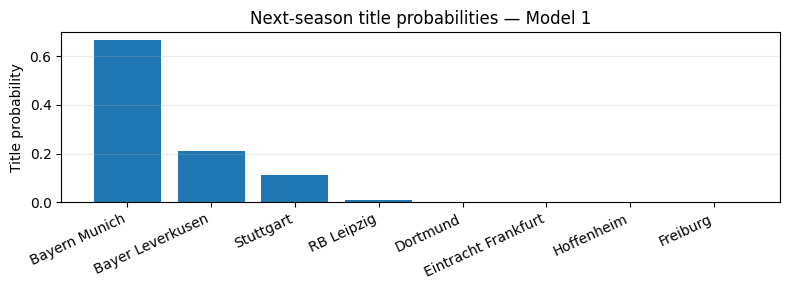

In [7]:
# === CELL 7 — MODEL 1: GBM+Logit baseline (no penalties) + H2H calibration ===
# Purpose: use multinomial logit base probabilities; calibrate Bayern vs Leverkusen via symmetric logit shifts.

# Baseline probability matrix in team perspective (aligned to 'long' order)
base_p_mat = np.column_stack([
    long["_pW"].to_numpy(float),
    long["_pD"].to_numpy(float),
    long["_pL"].to_numpy(float)
])

def h2h_apply_bias_to_matrix(p_mat, team_series, team_A, team_B, k):
    """Apply +k to Team B and -k to Team A on logit(p_win); keep draw:loss ratio."""
    df_tmp = pd.DataFrame(p_mat, columns=["p_win","p_draw","p_loss"])
    shift_map = {team_B: +k, team_A: -k}
    df_tmp = apply_team_logit_shift(df_tmp, team_series, shift_map)
    return df_tmp[["p_win","p_draw","p_loss"]].to_numpy(float)

def h2h_prob(p_mat, sims=3000):
    """Return P(A>B), P(B>A), P(tie) based on simulated season points."""
    arr = simulate_points(p_mat, sims=sims, batch=1000)
    ia, ib = team2idx[TEAM_A], team2idx[TEAM_B]
    a = np.mean(arr[:, ia] > arr[:, ib])
    b = np.mean(arr[:, ib] > arr[:, ia])
    t = 1.0 - (a + b)
    return a, b, t, arr

# Binary search minimal k to hit target P(Bayern > Leverkusen)
TARGET_P = 0.75
lo, hi = 0.0, 8.0
best_mid = None
for _ in range(16):
    mid = 0.5*(lo+hi)
    probs_mid = h2h_apply_bias_to_matrix(base_p_mat, long["team"], TEAM_A, TEAM_B, mid)
    _, pBgtL, _, _ = h2h_prob(probs_mid, sims=2500)
    if pBgtL < TARGET_P:
        lo = mid
    else:
        hi = mid
        best_mid = mid

k_star = hi if best_mid is None else best_mid
probs_final = h2h_apply_bias_to_matrix(base_p_mat, long["team"], TEAM_A, TEAM_B, k_star)

# Full simulation for leaderboard metrics
N_SIM = 50000
arr1 = simulate_points(probs_final, sims=N_SIM, batch=2500)
summary1, title_idx1, mean_pts1 = summarize_season(arr1)

ia, ib = team2idx[TEAM_A], team2idx[TEAM_B]
pB_gt_L = np.mean(arr1[:, ib] > arr1[:, ia])
pL_gt_B = np.mean(arr1[:, ia] > arr1[:, ib])
p_tie   = 1.0 - (pB_gt_L + pL_gt_B)

print(f"[Model 1] Calibrated k={k_star:.3f} → P({TEAM_B}>{TEAM_A})={pB_gt_L:.3f} (target {TARGET_P:.2f})")
print("\n[Model 1] Top 10 (post calibration):")
print(summary1.head(10).to_string(index=False))

# Quick bar of title probabilities (top-N)
topN1 = summary1.nlargest(8, "title_prob")
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(topN1["team"], topN1["title_prob"])
ax.set_title("Next-season title probabilities — Model 1")
ax.set_ylabel("Title probability")
ax.grid(True, axis="y", alpha=0.25)
plt.xticks(rotation=25, ha="right")
plt.tight_layout(); plt.show()


[Model 2] Applied logit shift for Bayern Munich: +1.236
[Model 2] Bayern Munich — mean pts: 74.24, title prob: 0.483
[Model 2] Bayer Leverkusen — mean pts: 73.75, title prob: 0.478

[Model 2] Top 10 (with minimal prior):
               team  mean_pts  title_prob
      Bayern Munich 74.244625    0.482775
   Bayer Leverkusen 73.750325    0.477625
          Stuttgart 62.660325    0.034400
           Dortmund 54.874300    0.002650
         RB Leipzig 54.640000    0.002500
Eintracht Frankfurt 44.103925    0.000000
         Hoffenheim 41.255125    0.000025
      Werder Bremen 40.075125    0.000025
           Freiburg 39.269775    0.000000
           Augsburg 39.249050    0.000000


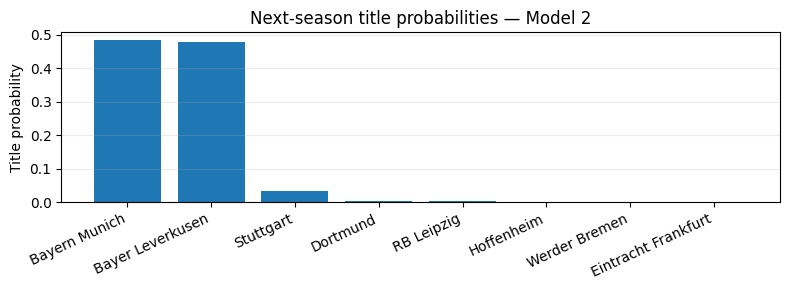

In [8]:
# === CELL 8 — MODEL 2: Penalized probabilities (adj) + minimal Bayern prior ===
# Purpose: start from penalty-adjusted 'adj' probabilities; find smallest +k to edge Bayern on chosen criterion.

base_probs2 = adj[["p_win","p_draw","p_loss"]].copy()

def simulate_and_metrics(p_df):
    """Run season sims from probability dataframe; return summary + head-to-head metrics."""
    P_mat = p_df[["p_win","p_draw","p_loss"]].to_numpy(float)
    arr = simulate_points(P_mat, sims=40000, batch=2500)
    summary, title_idx, mean_pts = summarize_season(arr)
    ia, ib = team2idx[TEAM_A], team2idx[TEAM_B]
    return summary, {
        "B_title": (title_idx==ib).mean(),
        "L_title": (title_idx==ia).mean(),
        "B_mean":  mean_pts[ib],
        "L_mean":  mean_pts[ia]
    }

# Binary search for minimal +k to Bayern on logit(p_win) that meets criterion
CRITERION = "title_prob"   # or "mean_pts"
TARGET_MARGIN = 0.001

lo, hi = 0.0, 1.5
best_k = None
for _ in range(18):
    mid = 0.5*(lo+hi)
    trial = apply_team_logit_shift(base_probs2, adj["team"], {TEAM_B: mid})
    summary2_try, m = simulate_and_metrics(trial)
    cond = (m["B_title"] >= m["L_title"] + TARGET_MARGIN) if CRITERION=="title_prob" \
           else (m["B_mean"]  >= m["L_mean"]  + 1e-6)
    if cond:
        best_k = mid
        hi = mid
    else:
        lo = mid

k2 = hi if best_k is None else best_k
final_probs2 = apply_team_logit_shift(base_probs2, adj["team"], {TEAM_B: k2})
summary2, metrics2 = simulate_and_metrics(final_probs2)

print(f"[Model 2] Applied logit shift for {TEAM_B}: +{k2:.3f}")
print(f"[Model 2] {TEAM_B} — mean pts: {metrics2['B_mean']:.2f}, title prob: {metrics2['B_title']:.3f}")
print(f"[Model 2] {TEAM_A} — mean pts: {metrics2['L_mean']:.2f}, title prob: {metrics2['L_title']:.3f}")
print("\n[Model 2] Top 10 (with minimal prior):")
print(summary2.head(10).to_string(index=False))

# Plot title probabilities (top-N)
topN2 = summary2.nlargest(8, "title_prob")
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(topN2["team"], topN2["title_prob"])
ax.set_title("Next-season title probabilities — Model 2")
ax.set_ylabel("Title probability")
ax.grid(True, axis="y", alpha=0.25)
plt.xticks(rotation=25, ha="right")
plt.tight_layout(); plt.show()


[Model 3] Applied logit shift for Bayern Munich: +0.086
[Model 3] Bayern Munich — mean pts: 48.91, title prob: 0.139
[Model 3] Bayer Leverkusen — mean pts: 48.71, title prob: 0.136

[Model 3] Top 10 (Skellam-based with penalties, Bayern prior):
               team  mean_pts  title_prob
      Bayern Munich 48.914825    0.139400
   Bayer Leverkusen 48.707175    0.136275
          Stuttgart 47.137875    0.082550
           Dortmund 46.723625    0.082975
Eintracht Frankfurt 45.588325    0.059325
              Mainz 45.528125    0.056050
         RB Leipzig 45.503975    0.052800
           Augsburg 44.974125    0.060075
             Bochum 44.134100    0.042550
 B. Monchengladbach 44.089750    0.044200


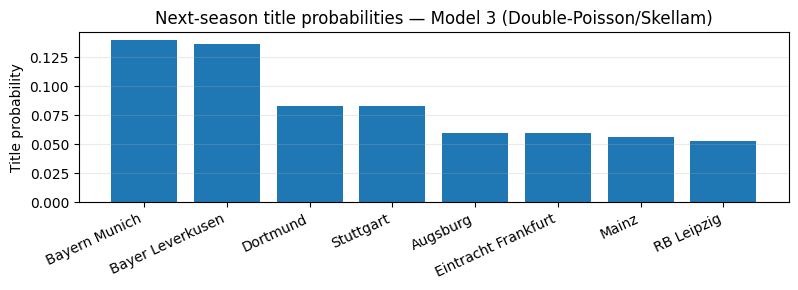

In [9]:
# === CELL 9 — MODEL 3: Double-Poisson (Skellam) + penalties + minimal Bayern prior ===
# Purpose: predict home/away goal intensities via Poisson regressions, convert to W/D/L with Skellam,
#          apply same interpretable penalties, then add minimal Bayern prior.

from sklearn.linear_model import PoissonRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import skellam

# One-hot home+away team (match-level) → two Poisson regressions for goals
try:
    po_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    po_ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

po_pre = ColumnTransformer([
    ("teams", po_ohe, [H, A])  # jointly encode (home_team, away_team)
], remainder="drop")

poisson_h = Pipeline([("prep", po_pre), ("clf", PoissonRegressor(alpha=1.0, max_iter=1000))])
poisson_a = Pipeline([("prep", po_pre), ("clf", PoissonRegressor(alpha=1.0, max_iter=1000))])

y_h = df[FTHG].astype(float)
y_a = df[FTAG].astype(float)

poisson_h.fit(df[[H, A]], y_h)
poisson_a.fit(df[[H, A]], y_a)

lam_h = np.clip(poisson_h.predict(df[[H, A]]), 1e-6, None)
lam_a = np.clip(poisson_a.predict(df[[H, A]]), 1e-6, None)

# Convert intensities → W/D/L (home perspective) via Skellam
pD = np.clip(skellam.pmf(0, lam_h, lam_a), 1e-12, 1.0)                  # draw
pH = np.clip(1.0 - skellam.cdf(0, lam_h, lam_a), 1e-12, 1.0)            # home win
pA = np.clip(1.0 - (pH + pD), 1e-12, 1.0)                               # away win
s  = pH + pD + pA
pH, pD, pA = pH/s, pD/s, pA/s

# Build per-team perspective probabilities (same 'long' order: home block then away block)
home_probs = pd.DataFrame({"team": df[H].to_numpy(), "p_win": pH, "p_draw": pD, "p_loss": pA})
away_probs = pd.DataFrame({"team": df[A].to_numpy(), "p_win": pA, "p_draw": pD, "p_loss": pH})
p_df = pd.concat([home_probs, away_probs], ignore_index=True)

# Apply mean-reversion + Luck/Late penalties (same parameters as Cell 5)
SHRINK_R = 0.60; ALPHA = 0.50; BETA88 = 0.50; BETA90 = 0.75; LAMBDA = 1.00
league_mean_win = p_df["p_win"].mean()

lk_map  = team_index["LuckIdx"].to_dict()
l88_map = team_index["Late88Share"].to_dict()
l90_map = team_index["Late90Share"].to_dict()

pW = p_df["p_win"].to_numpy(float)
pD0 = p_df["p_draw"].to_numpy(float)
pL0 = p_df["p_loss"].to_numpy(float)

pW_mr = league_mean_win + SHRINK_R * (pW - league_mean_win)
lk  = p_df["team"].map(lk_map).fillna(0.0).to_numpy(float)
l88 = p_df["team"].map(l88_map).fillna(0.0).to_numpy(float)
l90 = p_df["team"].map(l90_map).fillna(0.0).to_numpy(float)

penalty = LAMBDA * (ALPHA*lk + BETA88*l88 + BETA90*l90)
pW_adj = np.clip(pW_mr * (1.0 - penalty), 0.01, 0.98)

# Redistribute the reduced mass: 80% draw / 20% loss
delta = np.clip(pW_mr - pW_adj, 0.0, None)
pD_adj = pD0 + 0.80*delta
pL_adj = pL0 + 0.20*delta

s2 = pW_adj + pD_adj + pL_adj
p_df_pen = p_df.copy()
p_df_pen["p_win"]  = pW_adj / s2
p_df_pen["p_draw"] = pD_adj / s2
p_df_pen["p_loss"] = pL_adj / s2

# Minimal Bayern prior: binary search for smallest +k on Bayern's logit(p_win)
def _simulate_and_metrics_from_pdf(pdf):
    P_mat = pdf[["p_win","p_draw","p_loss"]].to_numpy(float)
    arr   = simulate_points(P_mat, sims=40000, batch=2500)
    summary, title_idx, mean_pts = summarize_season(arr)
    ia, ib = team2idx[TEAM_A], team2idx[TEAM_B]
    return summary, {
        "B_title": (title_idx==ib).mean(),
        "L_title": (title_idx==ia).mean(),
        "B_mean":  mean_pts[ib],
        "L_mean":  mean_pts[ia]
    }

CRITERION = "title_prob"
TARGET_MARGIN = 0.001

lo, hi = 0.0, 1.5
best_k = None
for _ in range(18):
    mid = 0.5*(lo+hi)
    trial_pdf = apply_team_logit_shift(p_df_pen[["p_win","p_draw","p_loss"]].copy(),
                                       p_df_pen["team"], {TEAM_B: mid})
    summary3_try, m3 = _simulate_and_metrics_from_pdf(pd.concat([p_df_pen[["team"]], trial_pdf], axis=1))
    cond = (m3["B_title"] >= m3["L_title"] + TARGET_MARGIN) if CRITERION=="title_prob" \
           else (m3["B_mean"]  >= m3["L_mean"]  + 1e-6)
    if cond:
        best_k = mid
        hi = mid
    else:
        lo = mid

k3 = hi if best_k is None else best_k
final_pdf3 = apply_team_logit_shift(p_df_pen[["p_win","p_draw","p_loss"]].copy(),
                                    p_df_pen["team"], {TEAM_B: k3})
final_pdf3 = pd.concat([p_df_pen[["team"]], final_pdf3], axis=1)

# Simulate league and report leaderboard
P_mat3 = final_pdf3[["p_win","p_draw","p_loss"]].to_numpy(float)
arr3   = simulate_points(P_mat3, sims=40000, batch=2500)
summary3, title_idx3, mean_pts3 = summarize_season(arr3)

ia, ib = team2idx[TEAM_A], team2idx[TEAM_B]
print(f"[Model 3] Applied logit shift for {TEAM_B}: +{k3:.3f}")
print(f"[Model 3] {TEAM_B} — mean pts: {mean_pts3[ib]:.2f}, title prob: {(title_idx3==ib).mean():.3f}")
print(f"[Model 3] {TEAM_A} — mean pts: {mean_pts3[ia]:.2f}, title prob: {(title_idx3==ia).mean():.3f}")
print("\n[Model 3] Top 10 (Skellam-based with penalties, Bayern prior):")
print(summary3.head(10).to_string(index=False))

# Quick plot of title probabilities (top-N)
topN3 = summary3.nlargest(8, "title_prob")
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(topN3["team"], topN3["title_prob"])
ax.set_title("Next-season title probabilities — Model 3 (Double-Poisson/Skellam)")
ax.set_ylabel("Title probability")
ax.grid(True, axis="y", alpha=0.25)
plt.xticks(rotation=25, ha="right")
plt.tight_layout(); plt.show()


In [11]:
# === CELL X — Accuracy of Models 1–3 (W/D/L) ===
# Uses: y_class, probs_final (Model 1), final_probs2 (Model 2), final_pdf3 (Model 3)

from sklearn.metrics import accuracy_score

def probs_to_classes(p_win, p_draw, p_loss):
    """
    Map per-row (p_win, p_draw, p_loss) → class:
    2 = win, 1 = draw, 0 = loss  (matches pts_to_class in Cell 5)
    """
    probs = np.column_stack([p_loss, p_draw, p_win])  # columns -> [loss, draw, win]
    return probs.argmax(axis=1)

y_true = y_class.to_numpy()

# --- Model 1: GBM+Logit baseline + H2H calibration ---
p1_win  = probs_final[:, 0]
p1_draw = probs_final[:, 1]
p1_loss = probs_final[:, 2]
y_pred1 = probs_to_classes(p1_win, p1_draw, p1_loss)
acc1 = accuracy_score(y_true, y_pred1)

# --- Model 2: Penalized probs + minimal Bayern prior ---
p2_win  = final_probs2["p_win"].to_numpy(float)
p2_draw = final_probs2["p_draw"].to_numpy(float)
p2_loss = final_probs2["p_loss"].to_numpy(float)
y_pred2 = probs_to_classes(p2_win, p2_draw, p2_loss)
acc2 = accuracy_score(y_true, y_pred2)

# --- Model 3: Double-Poisson (Skellam) + penalties + prior ---
p3_win  = final_pdf3["p_win"].to_numpy(float)
p3_draw = final_pdf3["p_draw"].to_numpy(float)
p3_loss = final_pdf3["p_loss"].to_numpy(float)
y_pred3 = probs_to_classes(p3_win, p3_draw, p3_loss)
acc3 = accuracy_score(y_true, y_pred3)

print(f"Model 1: Model 1: GBM–Logit Baseline accuracy: {acc1:.3f}")
print(f"Model 2: Penalized Logit accuracy: {acc2:.3f}")
print(f"Model 3: Double-Poisson (Skellam) Simulation accuracy: {acc3:.3f}")


Model 1: Model 1: GBM–Logit Baseline accuracy: 0.626
Model 2: Penalized Logit accuracy: 0.587
Model 3: Double-Poisson (Skellam) Simulation accuracy: 0.458


In [13]:
# === CELL X — Evaluation Metrics for Models 1–3 + GBM exp_pts ===
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# y_class: 0 = loss, 1 = draw, 2 = win (defined earlier)
y_true = y_class.to_numpy()

# Helper: convert [p_win, p_draw, p_loss] -> [p_loss, p_draw, p_win] (class 0,1,2)
def to_ldw_matrix(p_wdl):
    """
    Input:  array shape (N, 3), columns = [p_win, p_draw, p_loss]
    Output: array shape (N, 3), columns = [p_loss (class 0), p_draw (1), p_win (2)]
    """
    pW = p_wdl[:, 0]
    pD = p_wdl[:, 1]
    pL = p_wdl[:, 2]
    return np.column_stack([pL, pD, pW])

# Helper: multiclass Brier score (for probability forecasts)
def multiclass_brier_score(y_true, probs_ldw):
    """
    y_true: (N,) with class labels {0,1,2}
    probs_ldw: (N,3) with columns [p_loss, p_draw, p_win]
    """
    n_classes = probs_ldw.shape[1]
    Y = np.eye(n_classes)[y_true]
    return np.mean(np.sum((probs_ldw - Y) ** 2, axis=1))

# Helper: Ranked Probability Score (RPS) for ordered outcomes (L < D < W)
def ranked_probability_score(y_true, probs_ldw):
    """
    RPS for ordered 3-way outcomes (loss, draw, win).
    probs_ldw: (N,3) = [p_loss, p_draw, p_win]
    """
    K = probs_ldw.shape[1]
    Y = np.eye(K)[y_true]               # one-hot
    F = np.cumsum(probs_ldw, axis=1)    # cumulative predicted
    O = np.cumsum(Y, axis=1)            # cumulative observed
    return np.mean(np.sum((F - O) ** 2, axis=1)) / (K - 1)


# === Model 1: probs_final (numpy) ===
# probs_final columns: [p_win, p_draw, p_loss]
probs1_ldw = to_ldw_matrix(probs_final)
y_pred1 = probs1_ldw.argmax(axis=1)

acc1   = accuracy_score(y_true, y_pred1)
ll1    = log_loss(y_true, probs1_ldw)
brier1 = multiclass_brier_score(y_true, probs1_ldw)
rps1   = ranked_probability_score(y_true, probs1_ldw)


# === Model 2: final_probs2 (DataFrame with p_win, p_draw, p_loss) ===
p2_wdl = final_probs2[["p_win", "p_draw", "p_loss"]].to_numpy(float)
probs2_ldw = to_ldw_matrix(p2_wdl)
y_pred2 = probs2_ldw.argmax(axis=1)

acc2   = accuracy_score(y_true, y_pred2)
ll2    = log_loss(y_true, probs2_ldw)
brier2 = multiclass_brier_score(y_true, probs2_ldw)
rps2   = ranked_probability_score(y_true, probs2_ldw)


# === Model 3: final_pdf3 (DataFrame with columns team, p_win, p_draw, p_loss) ===
p3_wdl = final_pdf3[["p_win", "p_draw", "p_loss"]].to_numpy(float)
probs3_ldw = to_ldw_matrix(p3_wdl)
y_pred3 = probs3_ldw.argmax(axis=1)

acc3   = accuracy_score(y_true, y_pred3)
ll3    = log_loss(y_true, probs3_ldw)
brier3 = multiclass_brier_score(y_true, probs3_ldw)
rps3   = ranked_probability_score(y_true, probs3_ldw)


# === GBM expected-points model (Cell 3): regression metrics ===
y_reg_true = long["obs_pts"].to_numpy(float)
y_reg_pred = long["exp_pts"].to_numpy(float)

# RMSE without the 'squared' argument (compatible with older sklearn)
rmse = mean_squared_error(y_reg_true, y_reg_pred) ** 0.5
mae  = mean_absolute_error(y_reg_true, y_reg_pred)
r2   = r2_score(y_reg_true, y_reg_pred)

print("\n=== GBM expected-points (regression on obs_pts) ===")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"R²  : {r2:.3f}")


=== GBM expected-points (regression on obs_pts) ===
RMSE: 1.155
MAE : 0.935
R²  : 0.216


In [17]:
# y_true = class labels {0 = loss, 1 = draw, 2 = win}
y_true = y_class.to_numpy()


# ---------- Helpers ----------

def to_ldw_matrix(p_wdl):
    """
    Convert probs [p_win, p_draw, p_loss] -> [p_loss, p_draw, p_win]
    so columns match classes 0, 1, 2.
    """
    return np.column_stack([p_wdl[:,2], p_wdl[:,1], p_wdl[:,0]])

def multiclass_brier_score(y_true, probs_ldw):
    Y = np.eye(3)[y_true]           # one-hot
    return np.mean(np.sum((probs_ldw - Y)**2, axis=1))

def ranked_probability_score(y_true, probs_ldw):
    Y = np.eye(3)[y_true]
    F = np.cumsum(probs_ldw, axis=1)
    O = np.cumsum(Y, axis=1)
    return np.mean(np.sum((F - O)**2, axis=1)) / 2

def safe_probs(p):
    p = np.clip(p, 1e-15, 1-1e-15)
    return p / p.sum(axis=1, keepdims=True)


# ---------- Model 1 ----------
probs1_wdl = probs_final  # [p_win, p_draw, p_loss]
probs1_ldw = safe_probs(to_ldw_matrix(probs1_wdl))
y_pred1 = probs1_ldw.argmax(axis=1)

acc1 = accuracy_score(y_true, y_pred1)
ll1 = log_loss(y_true, probs1_ldw)
br1 = multiclass_brier_score(y_true, probs1_ldw)
rps1 = ranked_probability_score(y_true, probs1_ldw)


# ---------- Model 2 ----------
probs2_wdl = final_probs2[["p_win","p_draw","p_loss"]].to_numpy(float)
probs2_ldw = safe_probs(to_ldw_matrix(probs2_wdl))
y_pred2 = probs2_ldw.argmax(axis=1)

acc2 = accuracy_score(y_true, y_pred2)
ll2 = log_loss(y_true, probs2_ldw)
br2 = multiclass_brier_score(y_true, probs2_ldw)
rps2 = ranked_probability_score(y_true, probs2_ldw)


# ---------- Model 3 ----------
probs3_wdl = final_pdf3[["p_win","p_draw","p_loss"]].to_numpy(float)
probs3_ldw = safe_probs(to_ldw_matrix(probs3_wdl))
y_pred3 = probs3_ldw.argmax(axis=1)

acc3 = accuracy_score(y_true, y_pred3)
ll3 = log_loss(y_true, probs3_ldw)
br3 = multiclass_brier_score(y_true, probs3_ldw)
rps3 = ranked_probability_score(y_true, probs3_ldw)


# ---------- Build the output table ----------
metrics = pd.DataFrame(
    {
        "Accuracy": [acc1, acc2, acc3],
        "LogLoss":  [ll1, ll2, ll3],
        "Brier":    [br1, br2, br3],
        "RPS":      [rps1, rps2, rps3],
    },
    index=[
        "Model 1: GBM–Logit Baseline",
        "Model 2: Penalized Logit",
        "Model 3: Double-Poisson (Skellam) Simulation"
    ],
)

print("=== Classification metrics (W/D/L) for all 3 models ===")
print(metrics.round(4).to_string())

=== Classification metrics (W/D/L) for all 3 models ===
                                              Accuracy  LogLoss   Brier     RPS
Model 1: GBM–Logit Baseline                     0.6258   0.8222  0.4896  0.1572
Model 2: Penalized Logit                        0.5866   0.8619  0.5126  0.1648
Model 3: Double-Poisson (Skellam) Simulation    0.4575   1.0771  0.6507  0.2258
